# Estimador de Máxima Verossimilhança

## Introdução 

"Tradicionalmente a inferência estatística sobre a média de uma população se apoia no Teorema Central do Limite para construir Intervalos de Confiança ou testar hipóteses sobre o valor do parâmetro. Esta abordagem da estatística tradicional pode ser extendida para inferências a respeito de qualquer parâmetro, não só a média. Da mesma forma que no caso da média populacional se usa a distribuição *t-Student* ou a distribuição *Normal Padrão*, no caso de outros parâmetros se  utiliza outras distribuições amostrais. Essas distribuições são **chamadas amostrais porque representam o comportamento das estimativas baseado na repetição
incontável do processo de amostragem**.

Na prática científica, no entanto, sempre se realiza uma **única amostragem**, o
que resulta em uma única amostra. Assim, o conceito de distribuição amostral
é até certo ponto artificial, pois em pesquisa científica **não raciocinamos em termos de repetições incontáveis de experimentos ou processos de observação**. O
resultado disto é que o conceito de teste estatístico de hipótese e de intervalo de confiança são frequentemente mal compreendidos. 

O desenvolvimento da inferência estatística a partir do **conceito de verossimilhança tem sido utilizado como uma alternativa à abordagem estatística frequentista e, segundo alguns autores (como por exemplo Royall, 1997), é mais coerente
com a prática científica**." (Batista, 2009)

[Site de Referência](http://cmq.esalq.usp.br/BIE5781/lib/exe/fetch.php?media=leituras:verossim.pdf)

![Image-meme](../images/meme.png)

## Função Verossimilhança

Quando a função de densidade de probabilidade $f_n(x|\theta)$ das observações de uma amostra aleatória é vista como uma função de $\theta$, chamamos ela de função de verossimilhança.

$$
\theta \mapsto f_n(x|\theta) := L(\theta|x)
$$

## Estimador de Máxima Verossimilhança (MLE)

Para cada observação $x$, seja $\delta(x)$ um valor de $\theta \in \Omega$ tal que a função de verossimilhnaça seja **máxima**. Defina $\hat{\theta} = \delta(X)$ o estimador. 

É importante observar que o máximo dessa função pode não estar em um ponto de $\Omega$. Nesse caso, MLE não existe. Ele pode não estar unicamente definido, também. 

## Limitações 

- Não existência em todos os casos, isso depende muito da função e do espaço dos parâmetros. 
- Não unicidade em todos os casos.
- Não podemos interpretar MLE como o parâmetro mais provável, pois teríamos que ter um espaço de probabilidade associado ao parâmetro, o que não é dado. 

## Implementação

Como referência, estou utilizando [este site](https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f).

In [1]:
# importando bibliotecas

import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import pymc3 as pm3
import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
# Gerando os dados 
N = 100 
x = np.linspace(0, 20, N)  # gerando lista igualmente espaçada

beta1 = 3
beta0 = 0
sigma = 5 

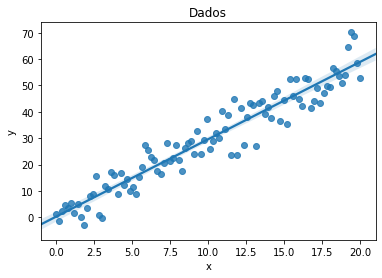

In [7]:
error = np.random.normal(0, sigma, size = N) 
y = beta1*x + beta0 + error 

data = pd.DataFrame({'y': y, 'x': x})
data['constant'] = 1

sns.regplot('x','y',data = data)  # Essa reta é uma estimativa dos dados feito por seaborn
plt.title('Dados')
plt.show()

$Y = \beta_1 x + \beta_0 + e$

Nesse exemplo, o nosso problema será estimar a média. Observe que os dados tem um comportamento linear. Sem nos concentrarmos muito na modelagem e os problemas que ela pode trazer, eu vou já supor que temos um problema de **Regressão Linear**, onde os dados $Y \sim N(\mu, \sigma^2)$, onde $\sigma^2$ é a variância do erro no processo, e $\mu = \beta_0 + \beta_1 x$, isto é, depende de x, nesse caso. Essa é uma dificuldade, as contas ficam mais difíceis e, por isso, vamos usar asrtifícios computacionais. Vamos supor que a variância é *conhecida*. Além disso, vamos supor que temos uma amostra aleatória $Y_i \sim N(\beta_0 + \beta_1 x_i, \sigma^2)$

Temos que a verossimilhança é produto das pdfs(distribuição de densidade de probabilidade). Para otimizar podemos, entretanto, obter a **soma dos logaritmos das pdfs**. E por fim, vamos resolver um problema de minimizar o negativo desse valor. Veja que é equivalente a maximixar a soma!!

In [8]:
# Função de verossimilhança. Chamamos de Função de Perda

def MLE(params):    # Função Perda: - log-verossimilhança 
    beta0, beta1 = params[0], params[1]
    # Modelo Linear
    yhat = beta0 + beta1*x  #= mu
    
    #loc é a média e scale desvio padrão. Note que sigma é conhecido
    negLikelihood = - np.sum(stats.norm.logpdf(y, loc = yhat, scale = sigma)) 
    
    return negLikelihood

In [9]:
# Esse é o chute inicial
initial_guess = np.array([3, 6])

results = minimize(MLE, initial_guess, method='Nelder-Mead', options = {'disp': True})

Optimization terminated successfully.
         Current function value: 307.745486
         Iterations: 56
         Function evaluations: 107


In [17]:
print(results)

 final_simplex: (array([[-1.03428809,  3.11012856],
       [-1.0342294 ,  3.110121  ],
       [-1.03433677,  3.11012912]]), array([293.95399071, 293.95399071, 293.95399071]))
           fun: 293.95399070678394
       message: 'Optimization terminated successfully.'
          nfev: 103
           nit: 55
        status: 0
       success: True
             x: array([-1.03428809,  3.11012856])


In [23]:
resultsdf = pd.DataFrame({'coef': results['x']})
resultsdf.index=[r'$\beta_0$',r'$\beta_1$']   
np.round(resultsdf.head(2), 4)

,coef
$\beta_0$,-1.0343
$\beta_1$,3.1101


Vamos estimar usando a biblioteca OLS. Ela faz esse processo e muito mais internamente. 

In [29]:
results_ols = sm.OLS(data.y, data[['constant', 'x']]).fit()
results_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1568.
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           4.22e-62
Time:                        21:20:55   Log-Likelihood:                -293.06
No. Observations:                 100   AIC:                             590.1
Df Residuals:                      98   BIC:                             595.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -1.0343      0.909     -1.138      0.258      -2.839       0.770
x              3.1101      0.079     39.599      0.000       2.954       3.266
==============================================================================
Omnibus:                        1.778   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.411   Jarque-Bera (JB):                1.423
Skew:                          -0.289   Prob(JB):                        0.491
Kurtosis:                       3.084   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Veja que a estimação dos coeficientes foi a mesma! Apesar de ambas estarem erradas p para $\beta_0$. Na verdade se olharmos o intervalo de confiança que OLS nos dá, vemos que de fato $0$ está nele. Mas ainda não esta na hora de vocês verem isso! 

## Conclusão 

Podemos usar uma função de perda (que no caso será menos a log-verossimilhança) e usar um algoritmo de otimização!


## Propriedades 

### Invariância 

Se $\hat{\theta}$ é o estimador de máxima verossimilhança de $\theta$ e $g$ é uma função injetiva, então $g(\hat{\theta})$ é o estimador de máxima verossimilhança de $g(\theta)$. Na verdade, podemos retirar condição de injetividade.  

#### MLE de uma Função

Seja $g(\theta)$ uma função arbitrária do parâmetro e $G = g(\Omega)$. Para cada $t \in G$, definimos $G_t := \{\theta : g(\theta) = t\}$ e 

$$L^*(t) := \max_{\theta \in G_t} log f_n(x|\theta)$$

Definimos a ML.E.de $g(\theta) := arg\,max_{t\in G} L^*(t)$

<img src="../images/mle_function.jpg" alt="mle_function" width="500"/>

#### Teorema 

Seja $\hat{\theta}$ MLE de $\theta$ e $g(\theta)$ função de $\theta$. Então uma MLE de $g(\theta)$ é $g(\hat{\theta})$. 

### Consistência

Suponha que para uma amostra suficientemente grantde, existe um MLE único para $\theta$. Então, sob algumas condições, a sequência de MLE é uma sequência consistente de estimadores de $\theta$. A seuqência convergee em probabilidade para o valor desconhecido de $\theta$. 

O mesmo acontece com o Estimador de Bayes, dadas condições de regularidade.

### Função Digamma: 

$$\frac{\Gamma'(\alpha)}{\Gamma(\alpha)}$$

### Método dos Momentos 

Assuma que a amostra aleatória $X_1,...,X_n$ vem da distribuição indexada pelo parâmetro $\theta$ k-dimensional. Por exemplo, a distribuição normal tem $k = 2$. Também suponha que pelo menos os $k$ primeiros momentos ($E[X_i^k] < \infty$) sejam finitos.  Defina $\mu_j(\theta) = E[X_1^j|\theta], j = 1,...k$. Suponha que a função:

$$
\begin{split}
\mu : ~&\Omega \to \mathbb{R}^k \\
&\theta \mapsto \mu(\theta) = (\mu_1(\theta), ..., \mu_k(\theta)),
\end{split}
$$
é injetiva em $\theta$. Seja $M(\mu_1,...,\mu_k)$ a função inversa, isto é, 
$$\theta = M(\mu_1,...,\mu_k)$$

O método dos momentos será $M(m_1,...,m_j)$, onde $m_j = \frac{1}{n}\sum_{i=1}^n X_i^j, j = 1,...,k$

De forma mais simplificada, basta que sesolvemos o sistema: 

$$m_j = \mu_j(\theta),$$

isto é, os momentos amostrais iguais aos momentos da amostra, condicionados em $\theta$. 

#### Teorema

Suponha que $\{X_n\}_{n\in\mathbb{N}}$ i.i.d com distribuição indexada pelo parâmetro $\theta$, $k$-dimensional. Suponha que os primeiros $k$ momentos existem e são finitos para todo $\theta$. Suponha que a inversa $M$ definida acima é contínua. Então a sequência de estimadores do método de momentos em $X_1,...,X_n$ é consistente. 

## M.L.E e Estimador de Bayes

Se tivermos condições de suavidade em $f(x|\theta)$, podemos provar que quando $n \to \infty$, teremos que:

$$L(\theta|x) \to c(x)\cdot \exp\{-\frac{1}{2V_n(\theta)/n}(\theta - \hat{\theta})^2\},$$

onde $\hat{\theta}$ é MLE e $V_n(\theta)$ é uma sequência de variáveis aleatórias convergente. 

No caso de termos uma priori relativamente flat, a posteriori será aproximadamente uma distribuição normal com média $\hat{\theta}$ e variância $V_n(\hat{\theta})/n$. 


#### Exemplo 7.6.12 (Mortes exército prússio)

Bortkiewicz contou o número de soldados mortos por horsekick em 14 unidades do exército em 20 anos, com 280 contagens ao total. Das contagens temos

|Valor|0|1|2|3|4|Total|
|-----|-|-|-|-|-|-|
|Contagem|144|91|32|11|2|280|

Modelamos $X_1, ..., X_{280}$ como uma variável de contagem. Considere a distribuição $Poisson(\theta)$. Escolhemos a distribuição $Gamma(\alpha,\beta)$, dada que ela pertence à familia conjungada. Em particular, a distribuição a posteriori será $Gamma(\alpha + \sum X_i, \beta + n)$, onde $\sum X_i = 196$. 

Se assumirmos $\alpha$ inteiro por simplicidade, vemos que a distribuição $Gamma$ pode ser vista como a soma de $\alpha + \sum X_i$ distribuições $Exponencial(\beta + n)$. Logo a soma dessas variáveis será aproximadamente normal com média $196/280$ e variância $196/280^2$. 

In [32]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import gamma

In [33]:
alpha = 1
beta = 1

# Esse é o MLE, a média. Vou supor que esse é o parâmetro verdadeiro só para mostrar. 
theta = 196/280   

sum_xi = 196

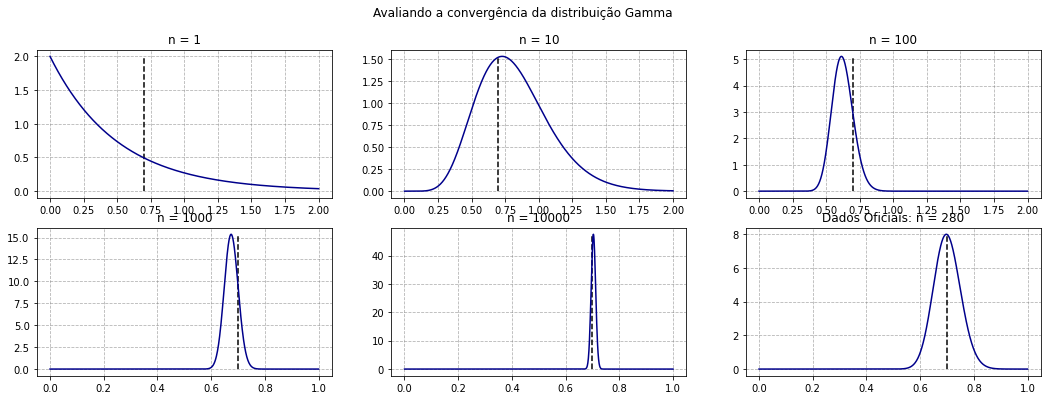

In [81]:
fig, ax = plt.subplots(2,3,figsize = (18,6))
fig.suptitle('Avaliando a convergência da distribuição Gamma')

for index, n in enumerate([1,10,100,1000,10000,280]):
    
    i = int(index/3)
    j = index % 3 
    
    X = np.random.poisson(theta, size = n)
    if n != 280: 
        T = X.sum()
        ax[i][j].set_title('n = {}'.format(n))
    else:
        T = sum_xi  #Valor dos dados
        ax[i][j].set_title('Dados Oficiais: n = {}'.format(n))
    
    t = np.linspace(start = 0.00001, stop = 3 - i - 1, num = 1000)
    
    posteriori = gamma(alpha + T, scale = 1/(beta  + n))
    y = posteriori.pdf(t)
    
    ax[i][j].plot(t, y, color = 'darkblue')
    ax[i][j].grid(color = 'grey', alpha = 0.6, linestyle = '--')
    ax[i][j].vlines(theta, ymin = 0, ymax = max(y), 
                   color = 'black', linestyle = '--')

Veja que com os dados reais, já temos uma boa aproximação!

# O algoritmo EM

Na próxima semana!

- [Curso Stanford](http://cs229.stanford.edu/notes/cs229-notes8.pdf)

- [Medium](https://medium.com/@jonathan_hui/machine-learning-expectation-maximization-algorithm-em-2e954cb76959)

- [Computação](https://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html)